# Lab 2 NLP
### - Christian Hernández
### - Felipe Toscano

### Lib and Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score



# Descargar los recursos necesarios de NLTK
nltk.download('wordnet') # base lexica en ingles para lematizacion
nltk.download('omw-1.4') #proporciona soporte para multilengua wordnet
nltk.download('punkt') # tokenizador preentrenado que NLTK

# Cargar dataset
data = pd.read_csv('/content/drive/MyDrive/MAESTRIA IA/NLP/lab2/train.tsv', sep='\t')

rand_seed = 123

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Exploratory Data Analysis

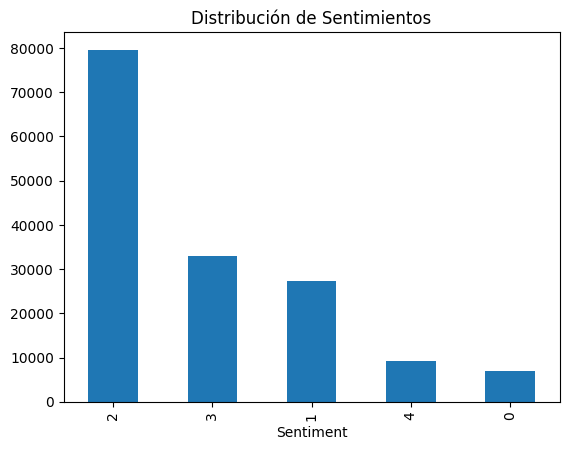

In [ ]:
# Distribución de etiquetas
data['Sentiment'].value_counts().plot(kind='bar')
plt.title('Distribución de Sentimientos')
plt.show()




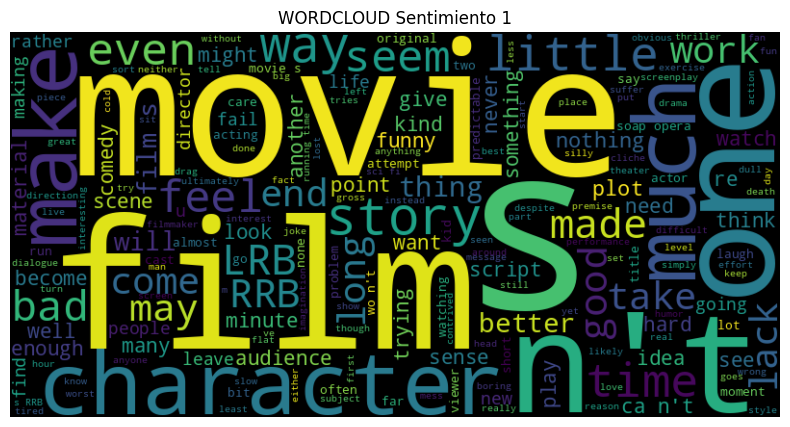

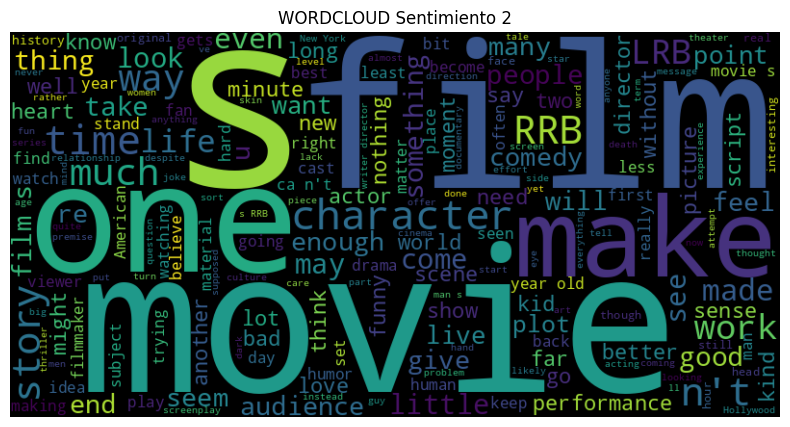

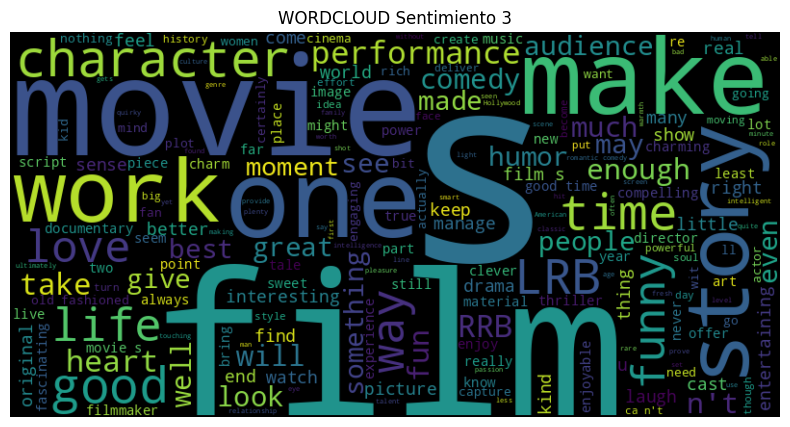

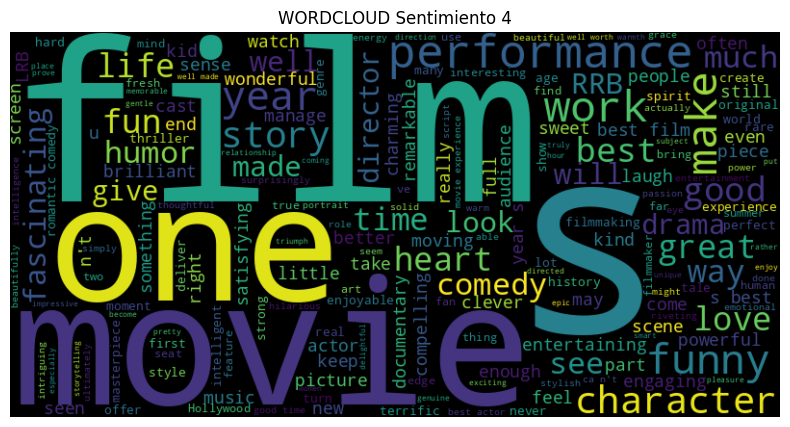

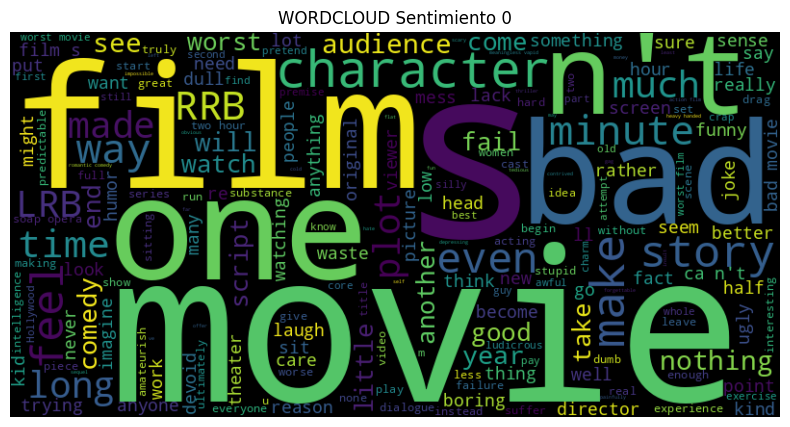

In [ ]:
# Palabras más comunes por sentimiento  WORDCLOUD
for sentiment in data['Sentiment'].unique():
    text = ' '.join(data[data['Sentiment'] == sentiment]['Phrase'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'WORDCLOUD Sentimiento {sentiment}')
    plt.axis('off')
    plt.show()

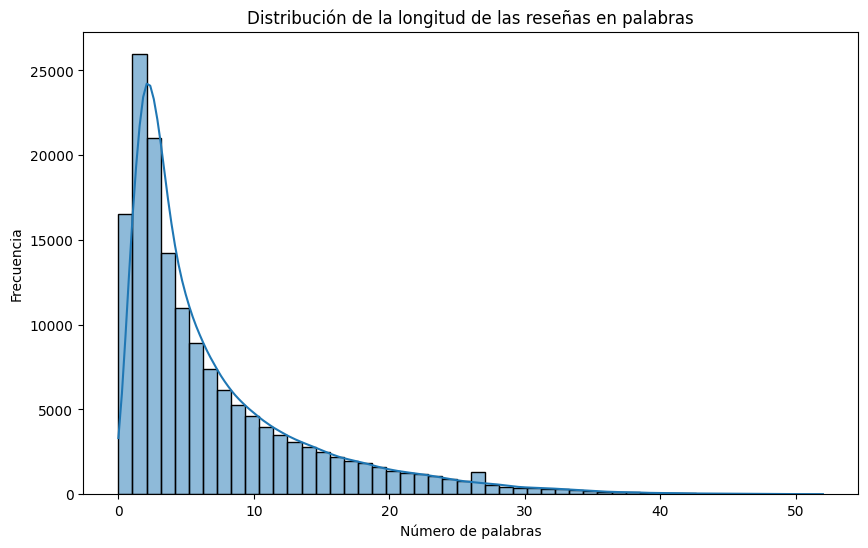

In [ ]:

# Longitud de las reseñas en palabras
data['length_words'] = data['Phrase'].apply(lambda x: len(x.split()))



# Visualización de la distribución de longitud de las resenas en en palabras
plt.figure(figsize=(10, 6))
sns.histplot(data['length_words'], bins=50, kde=True)
plt.title('Distribución de la longitud de las reseñas en palabras')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.show()




In [ ]:
# imprimir uan reseña
print(data['Phrase'][0])
print("------------")
# imprimir la reseña mas corta
print(data['Phrase'][data['length_words'].idxmin()])
print("------------")
# imprimir la reseña mas larga
print(data['Phrase'][data['length_words'].idxmax()])

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
------------
 
------------
It cuts to the core of what it actually means to face your fears , to be a girl in a world of boys , to be a boy truly in love with a girl , and to ride the big metaphorical wave that is life -- wherever it takes you .


In [ ]:
# elimina resenas con len = 0
data = data[data['length_words'] != 0]

In [ ]:
# imprimir uan reseña
print(data['Phrase'][0])
print("------------")
# imprimir la reseña mas corta
print(data['Phrase'][data['length_words'].idxmin()])
print("------------")
# imprimir la reseña mas larga
print(data['Phrase'][data['length_words'].idxmax()])

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
------------
A
------------
It cuts to the core of what it actually means to face your fears , to be a girl in a world of boys , to be a boy truly in love with a girl , and to ride the big metaphorical wave that is life -- wherever it takes you .


In [ ]:
data.head(30)

,PhraseId,SentenceId,Phrase,Sentiment,length_words,tokens,stemmed,lemmatized
0,1,1,A series of escapades demonstrating the adage ...,1,37,"[A, series, of, escapades, demonstrating, the,...",a seri of escapad demonstr the adag that what ...,A series of escapade demonstrating the adage t...
1,2,1,A series of escapades demonstrating the adage ...,2,14,"[A, series, of, escapades, demonstrating, the,...",a seri of escapad demonstr the adag that what ...,A series of escapade demonstrating the adage t...
2,3,1,A series,2,2,"[A, series]",a seri,A series
3,4,1,A,2,1,[A],a,A
4,5,1,series,2,1,[series],seri,series
5,6,1,of escapades demonstrating the adage that what...,2,12,"[of, escapades, demonstrating, the, adage, tha...",of escapad demonstr the adag that what is good...,of escapade demonstrating the adage that what ...
6,7,1,of,2,1,[of],of,of
7,8,1,escapades demonstrating the adage that what is...,2,11,"[escapades, demonstrating, the, adage, that, w...",escapad demonstr the adag that what is good fo...,escapade demonstrating the adage that what is ...
8,9,1,escapades,2,1,[escapades],escapad,escapade
9,10,1,demonstrating the adage that what is good for ...,2,10,"[demonstrating, the, adage, that, what, is, go...",demonstr the adag that what is good for the goos,demonstrating the adage that what is good for ...


In [ ]:
from collections import Counter

def palabras_comunes_por_sentimiento(data, sentimiento, n=20):
    palabras = ' '.join(data[data['Sentiment'] == sentimiento]['Phrase']).split()
    palabras_comunes = Counter(palabras).most_common(n)
    return pd.DataFrame(palabras_comunes, columns=['Palabra', 'Frecuencia'])

# Mostrar las palabras más comunes para cada sentimiento
for sentimiento in data['Sentiment'].unique():
    print(f"Sentimiento {sentimiento}:")
    display(palabras_comunes_por_sentimiento(data, sentimiento))


Sentimiento 1:


,Palabra,Frecuencia
0,the,9712
1,",",8847
2,a,7327
3,of,6552
4,and,6078
5,to,5437
6,.,4432
7,'s,3506
8,is,3324
9,that,2941


Sentimiento 2:


,Palabra,Frecuencia
0,the,18638
1,",",13141
2,of,12126
3,a,11297
4,and,10062
5,to,8167
6,'s,7001
7,in,5370
8,.,4114
9,is,3634


Sentimiento 3:


,Palabra,Frecuencia
0,",",11417
1,the,11313
2,and,9080
3,a,8936
4,of,8309
5,to,5339
6,.,4766
7,'s,3999
8,is,3472
9,that,3249


Sentimiento 4:


,Palabra,Frecuencia
0,",",4879
1,and,3968
2,the,3819
3,a,3311
4,of,3022
5,.,2280
6,is,1547
7,to,1540
8,'s,1329
9,that,1248


Sentimiento 0:


,Palabra,Frecuencia
0,",",3722
1,the,3070
2,a,2572
3,and,2507
4,of,2236
5,.,1973
6,to,1880
7,is,1363
8,'s,1136
9,that,1130


### Tokenization

Se usa el modulo punkt de NLTK para tokenizar las frases
https://www.nltk.org/api/nltk.tokenize.punkt.html

In [ ]:
# Tokenización
data['tokens'] = data['Phrase'].apply(word_tokenize)

print(data['tokens'][0])

['A', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', ',', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story', '.']


### Bag of Words

In [ ]:
vectorizer = CountVectorizer()

# Transformar el texto en una matriz de características
X = vectorizer.fit_transform(data['Phrase'])

# Ver las características creadas
print(X.shape)  # Número de frases x número de características

# visualizar matriz en un DataFrame
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

print(X_df.head(10))

# cada fila es unaa frase y cada columna una caracteristica


(156059, 15240)
   000  10  100  101  102  103  104  105  10th  11  ...  ziyi  zoe  zombie  \
0    0   0    0    0    0    0    0    0     0   0  ...     0    0       0   
1    0   0    0    0    0    0    0    0     0   0  ...     0    0       0   
2    0   0    0    0    0    0    0    0     0   0  ...     0    0       0   
3    0   0    0    0    0    0    0    0     0   0  ...     0    0       0   
4    0   0    0    0    0    0    0    0     0   0  ...     0    0       0   
5    0   0    0    0    0    0    0    0     0   0  ...     0    0       0   
6    0   0    0    0    0    0    0    0     0   0  ...     0    0       0   
7    0   0    0    0    0    0    0    0     0   0  ...     0    0       0   
8    0   0    0    0    0    0    0    0     0   0  ...     0    0       0   
9    0   0    0    0    0    0    0    0     0   0  ...     0    0       0   

   zone  zoning  zoolander  zoom  zucker  zwick  zzzzzzzzz  
0     0       0          0     0       0      0          0  
1  

In [ ]:
# para la primera frase
print("Frase:", data['Phrase'].iloc[0])

# representacion de caracteristicas
print("Vector de características:\n", X_df.iloc[0])


Frase: A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
Vector de características:
 000          0
10           0
100          0
101          0
102          0
            ..
zoolander    0
zoom         0
zucker       0
zwick        0
zzzzzzzzz    0
Name: 0, Length: 15240, dtype: int64


### modelo de Naive Bayes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, data['Sentiment'], test_size=0.2, random_state=rand_seed)

# Definir el modelo de Naive Bayes
model = MultinomialNB()

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6090606177111367
              precision    recall  f1-score   support

           0       0.42      0.29      0.34      1433
           1       0.48      0.44      0.46      5318
           2       0.70      0.77      0.73     15995
           3       0.52      0.50      0.51      6585
           4       0.46      0.31      0.37      1881

    accuracy                           0.61     31212
   macro avg       0.52      0.46      0.48     31212
weighted avg       0.60      0.61      0.60     31212



### Naive Bayes con ajustes en BOW

- remove stop words
- case folding
- stemming
- lemmatization
- instead of using a 0/1 (binary) vector, use the number of times that a word occurs in the text

In [ ]:
# Tokenización
data['tokens'] = data['Phrase'].apply(word_tokenize)

# Stemming
stemmer = PorterStemmer()
data['stemmed'] = data['tokens'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))

# Lematización
lemmatizer = WordNetLemmatizer()
data['lemmatized'] = data['tokens'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

# Vectorización usando la frecuencia de palabras
# Remove Stop Words, Case Folding y Use the Number of Times that a Word Occurs
vectorizer = CountVectorizer(stop_words='english', lowercase=True, binary=False)
X = vectorizer.fit_transform(data['lemmatized'])

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, data['Sentiment'], test_size=0.2, random_state=rand_seed)

# Entrenamiento del modelo
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

data.head(30)


,PhraseId,SentenceId,Phrase,Sentiment,length_words,tokens,stemmed,lemmatized
0,1,1,A series of escapades demonstrating the adage ...,1,37,"[A, series, of, escapades, demonstrating, the,...",a seri of escapad demonstr the adag that what ...,A series of escapade demonstrating the adage t...
1,2,1,A series of escapades demonstrating the adage ...,2,14,"[A, series, of, escapades, demonstrating, the,...",a seri of escapad demonstr the adag that what ...,A series of escapade demonstrating the adage t...
2,3,1,A series,2,2,"[A, series]",a seri,A series
3,4,1,A,2,1,[A],a,A
4,5,1,series,2,1,[series],seri,series
5,6,1,of escapades demonstrating the adage that what...,2,12,"[of, escapades, demonstrating, the, adage, tha...",of escapad demonstr the adag that what is good...,of escapade demonstrating the adage that what ...
6,7,1,of,2,1,[of],of,of
7,8,1,escapades demonstrating the adage that what is...,2,11,"[escapades, demonstrating, the, adage, that, w...",escapad demonstr the adag that what is good fo...,escapade demonstrating the adage that what is ...
8,9,1,escapades,2,1,[escapades],escapad,escapade
9,10,1,demonstrating the adage that what is good for ...,2,10,"[demonstrating, the, adage, that, what, is, go...",demonstr the adag that what is good for the goos,demonstrating the adage that what is good for ...


In [ ]:
print("Accuracy after data transformation:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy after data transformation: 0.6112713059079841
              precision    recall  f1-score   support

           0       0.43      0.28      0.34      1433
           1       0.49      0.40      0.44      5318
           2       0.68      0.80      0.74     15995
           3       0.52      0.49      0.50      6585
           4       0.50      0.28      0.36      1881

    accuracy                           0.61     31212
   macro avg       0.53      0.45      0.48     31212
weighted avg       0.59      0.61      0.60     31212



Como afecto al modelo?

Los resultados son practicamente iguales antes y despues del preprocesamiento debido a varios factores:
el modelo Naive Bayes no logra capturar la complejidad de los datos, cada palabra es independiente del sentimiento y el hecho que el dataset esta desbalancedo podria contribuir a este efecto.
